In [20]:
import pandas as pd

# Load merged dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

# Example: Predict if the container will reach 75% fill within the next 24 hours
df['Threshold_Reached'] = (df['Fill_Level'] >= 75).astype(int)



In [21]:


# Specify the columns to fill with zero
columns_to_fill = ['Truck_ID', 'Total_Distance_km', 'Travel_Time_min', 'Fuel_Cost_USD', 'Latitude_Truck', 'Longitude_Truck']

# Fill NaN or empty values
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Optional: If Truck_ID should remain a string type with '0' instead of numeric 0
df['Truck_ID'] = df['Truck_ID'].replace(0, '0')

# Save the updated dataset
df.to_csv('final_dataset_truck_fields_filled_1.csv', index=False)

print("Truck fields filled with zeros and dataset saved as 'final_dataset_truck_fields_filled_1.csv'.")


Truck fields filled with zeros and dataset saved as 'final_dataset_truck_fields_filled_1.csv'.


In [2]:
from sklearn.preprocessing import LabelEncoder

# Encode Waste Type
le = LabelEncoder()
df['Waste_Type_Encoded'] = le.fit_transform(df['Waste_Type'])

# Extract Time Features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

features = ['Fill_Level', 'Waste_Type_Encoded', 'Hour', 'DayOfWeek', 'Total_Distance_km', 'Fuel_Cost_USD']
target = 'Threshold_Reached'

X = df[features]
y = df[target]


In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")


[LightGBM] [Info] Number of positive: 11673, number of negative: 28327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291825 -> initscore=-0.886537
[LightGBM] [Info] Start training from score -0.886537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [5]:

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

locations = df[['Latitude_Container', 'Longitude_Container']].drop_duplicates().values
num_locations = len(locations)

distance_matrix = np.zeros((num_locations, num_locations))
for i in range(num_locations):
    for j in range(num_locations):
        distance_matrix[i, j] = haversine(*locations[i], *locations[j])


In [4]:
import pandas as pd

# Load merged dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

# Focus on a single container for time series modeling
container_id = 'C_069'  # Example container
container_df = df[df['Container_ID'] == container_id].copy()

# Convert Timestamp and set as index
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.set_index('Timestamp', inplace=True)

# Use only the 'Fill_Level' column
ts_data = container_df['Fill_Level'].resample('h').mean().interpolate()


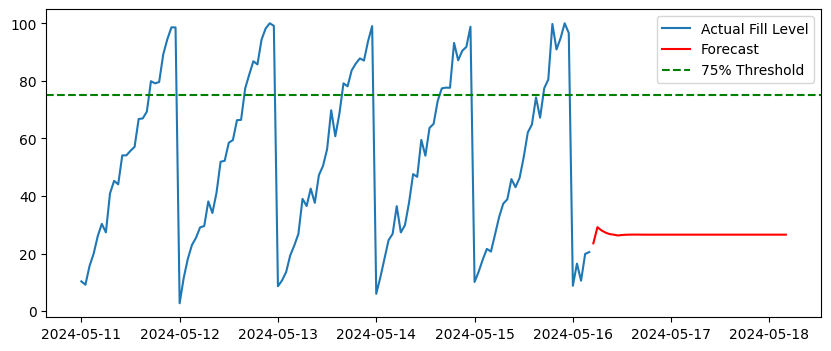

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Split data into train and test
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Train ARIMA Model (order can be optimized using AIC/BIC or auto_arima)
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast next 24 hours (or any desired horizon)
forecast_steps = 48
forecast = model_fit.forecast(steps=forecast_steps)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_data.index, ts_data, label='Actual Fill Level')
plt.plot(pd.date_range(ts_data.index[-1], periods=forecast_steps+1, freq='h')[1:], forecast, label='Forecast', color='red')
plt.axhline(y=75, color='green', linestyle='--', label='75% Threshold')
plt.legend()
plt.show()


In [21]:
forecast_series = pd.Series(forecast, index=pd.date_range(ts_data.index[-1], periods=forecast_steps+1, freq='H')[1:])
time_to_threshold = forecast_series[forecast_series >= 75]

if not time_to_threshold.empty:
    print(f"Predicted to reach 75% at: {time_to_threshold.index[0]}")
else:
    print("Threshold of 75% not reached in the forecast horizon.")


Threshold of 75% not reached in the forecast horizon.


/tmp/ipykernel_31/83490655.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_series = pd.Series(forecast, index=pd.date_range(ts_data.index[-1], periods=forecast_steps+1, freq='H')[1:])
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


13:42:48 - cmdstanpy - INFO - Chain [1] start processing
13:42:51 - cmdstanpy - INFO - Chain [1] done processing


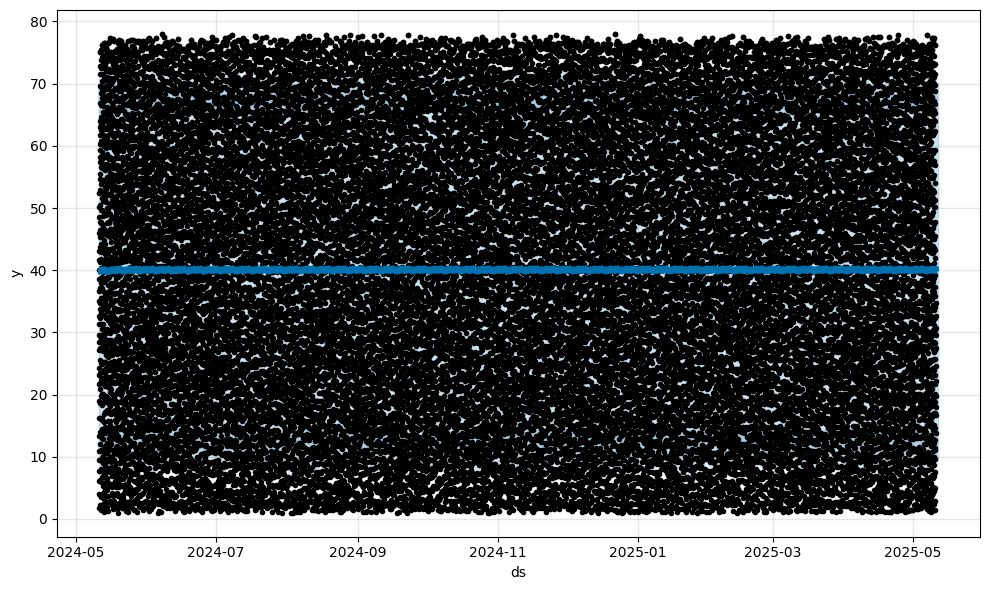

In [26]:
from prophet import Prophet
prophet_df = container_df.reset_index()[['Timestamp', 'Fill_Level']]
prophet_df.columns = ['ds', 'y']

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=24, freq='h')
forecast = model.predict(future)

fig = model.plot(forecast)


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('final_dataset_truck_fields_filled_1.csv')

# Select one container for demonstration
container_id = 'C_001'
container_df = df[df['Container_ID'] == container_id].copy()

# Convert timestamp and sort
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.sort_values('Timestamp', inplace=True)
ts_data = container_df[['Timestamp', 'Fill_Level']].set_index('Timestamp').resample('h').mean().interpolate()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Last 24 hours to predict the next hour
X, y = create_sequences(scaled_data, seq_length)

# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.1051 - val_loss: 0.0600
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0387 - val_loss: 0.0324
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0291 - val_loss: 0.0232
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0239 - val_loss: 0.0192
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0216 - val_loss: 0.0223
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0185 - val_loss: 0.0153
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0172 - val_loss: 0.0149
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0145 - val_loss: 0.0121
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/ste

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


AttributeError: 'Sequential' object has no attribute 'plot'

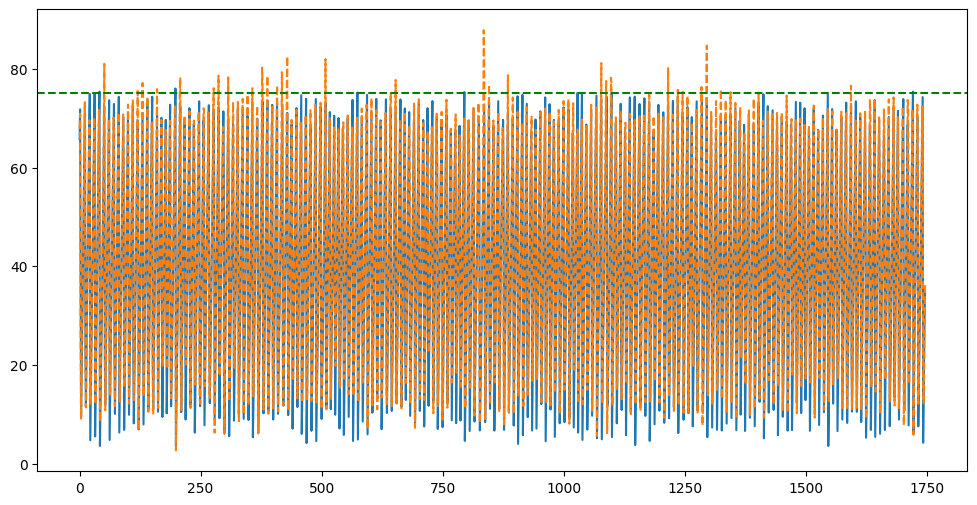

In [31]:
import matplotlib.pyplot as plt

# Predict and inverse transform
predictions = model.predict(X_test)

predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Fill Level')
plt.plot(predictions_inverse, label='Predicted Fill Level', linestyle='--')
plt.axhline(y=75, color='green', linestyle='--', label='75% Threshold')
# Save Forecast Plot with Time Range Limited to Last Week
fig = model.plot(forecast)
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.title(f"Forecast for Container {container_id}")
plt.legend()
plt.tight_layout()

# Limit x-axis to last 7 days
last_date = container_df['ds'].max()
first_date = last_date - pd.Timedelta(days=7)
plt.xlim([first_date, last_date])

plot_path = f"container_forecast_plots/Forecast_{container_id}.png"
plt.savefig(plot_path)
plt.close()



AttributeError: 'Sequential' object has no attribute 'plot'

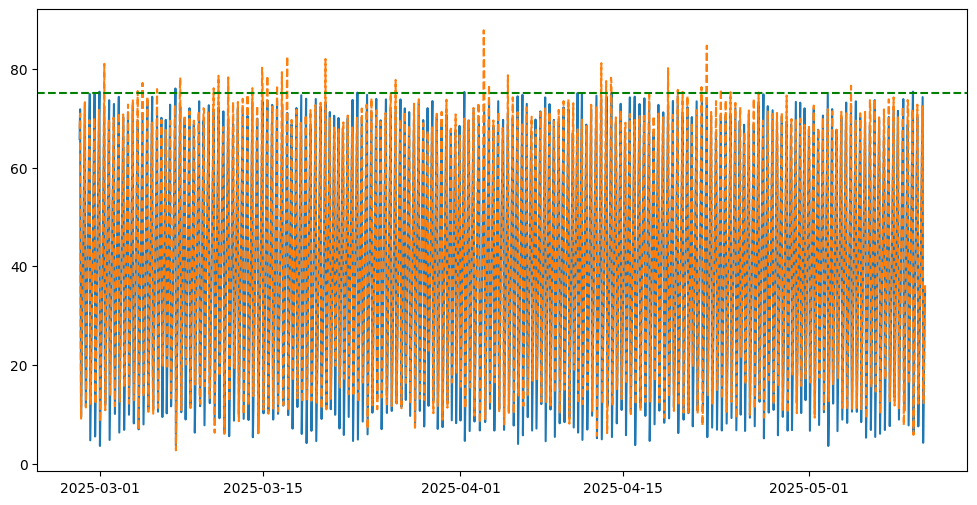

In [32]:
# Prepare proper timestamps for the x-axis
timestamps = ts_data.index[-len(y_test_inverse):]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, y_test_inverse, label='Actual Fill Level')
plt.plot(timestamps, predictions_inverse, label='Predicted Fill Level', linestyle='--')
plt.axhline(y=75, color='green', linestyle='--', label='75% Threshold')
# Save Forecast Plot with Time Range Limited to Last Week
fig = model.plot(forecast)
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.title(f"Forecast for Container {container_id}")
plt.legend()
plt.tight_layout()

# Limit x-axis to last 7 days
last_date = container_df['ds'].max()
first_date = last_date - pd.Timedelta(days=7)
plt.xlim([first_date, last_date])

plot_path = f"container_forecast_plots/Forecast_{container_id}.png"
plt.savefig(plot_path)
plt.close()

plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.title(f"Container Fill Level Forecast for {container_id}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [39]:
import pandas as pd

# Load data
df = pd.read_csv('/kaggle/input/merged-container-truck-data-csv/merged_container_truck_data.csv')

# Get list of unique containers
container_ids = df['Container_ID'].unique()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# LSTM Parameters
seq_length = 24  # Last 24 hours to predict next hour
epochs = 10      # Reduce for faster testing

for container_id in container_ids:
    container_df = df[df['Container_ID'] == container_id].copy()
    container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
    container_df.sort_values('Timestamp', inplace=True)
    ts_data = container_df[['Timestamp', 'Fill_Level']].set_index('Timestamp').resample('H').mean().interpolate()

    if len(ts_data) <= seq_length:
        continue  # Skip if not enough data

    # Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(ts_data)

    # Create sequences
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, seq_length)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build LSTM
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    # Predict and inverse transform
    predictions = model.predict(X_test)
    predictions_inverse = scaler.inverse_transform(predictions)
    y_test_inverse = scaler.inverse_transform(y_test)

    # Prepare timestamps for x-axis
    timestamps = ts_data.index[-len(y_test_inverse):]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, y_test_inverse, label='Actual Fill Level')
    #plt.plot(timestamps, predictions_inverse, label='Predicted Fill Level', linestyle='--')
    plt.axhline(y=75, color='green', linestyle='--', label='75% Threshold')
    plt.title(f"Container: {container_id}")
    plt.xlabel("Time")
    plt.ylabel("Fill Level (%)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('merged_container_truck_data.csv')

# Example: Select containers that have fill level ≥ 75% (urgent)
urgent_df = df[df['Fill_Level'] >= 75].drop_duplicates('Container_ID')
locations = urgent_df[['Latitude_Container', 'Longitude_Container']].values

# Add depot (waste facility location), assuming it’s the first location
depot_location = [51.1694, 71.4491]  # Example: Astana center
locations = np.vstack([depot_location, locations])

num_locations = len(locations)


In [7]:
import pandas as pd

# Load merged dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

In [8]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the final dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

# Example: Select one container for forecasting
container_id = 'C_001'
container_df = df[df['Container_ID'] == container_id][['Timestamp', 'Fill_Level']].copy()

# Prepare data for Prophet
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df = container_df.rename(columns={'Timestamp': 'ds', 'Fill_Level': 'y'})


In [11]:
# Initialize and configure Prophet
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

# Fit the model
model.fit(container_df)


13:26:41 - cmdstanpy - INFO - Chain [1] start processing
13:26:45 - cmdstanpy - INFO - Chain [1] done processing


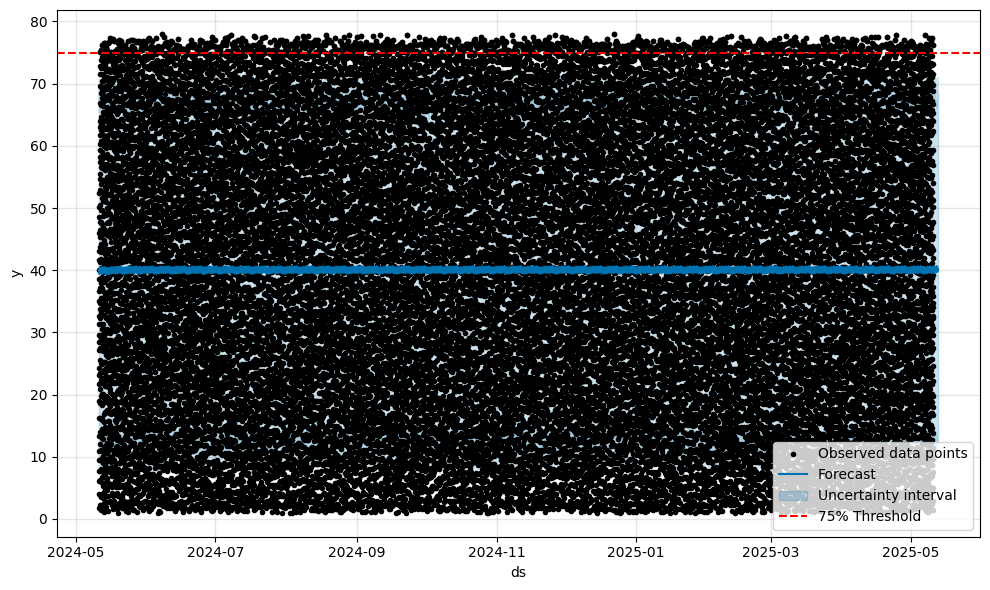

In [12]:
# Define how far into the future you want to predict (e.g., next 48 hours)
future = model.make_future_dataframe(periods=48, freq='h')  # 48 future hours

# Generate forecast
forecast = model.predict(future)

# Visualize forecast
fig = model.plot(forecast)
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.legend()
plt.show()


In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import os

# Load the dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

# Create a directory to store plots
os.makedirs('container_forecast_plots', exist_ok=True)

# Prepare a results list to store predictions
predictions = []

# Get unique container IDs
container_ids = df['Container_ID'].unique()

for container_id in container_ids:
    # Filter data for the current container
    container_df = df[df['Container_ID'] == container_id][['Timestamp', 'Fill_Level']].copy()

    # Skip if insufficient data
    if len(container_df) < 50:
        continue

    # Prepare data for Prophet
    container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
    container_df = container_df.rename(columns={'Timestamp': 'ds', 'Fill_Level': 'y'})

    # Initialize Prophet model
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    try:
        # Fit model
        model.fit(container_df)

        # Forecast next 48 hours
        future = model.make_future_dataframe(periods=120, freq='h')
        forecast = model.predict(future)

        # Find when fill level will reach or exceed 75%
        forecast_75 = forecast[forecast['yhat'] >= 75]

        if not forecast_75.empty:
            predicted_time = forecast_75.iloc[0]['ds']
        else:
            predicted_time = "Not Reached in Forecast Horizon"

        # Append prediction result
        predictions.append({'Container_ID': container_id, 'Predicted_Time_to_75%': predicted_time})

        # Save Forecast Plot
        fig = model.plot(forecast)
        plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
        plt.title(f"Forecast for Container {container_id}")
        plt.legend()
        plt.tight_layout()
        plot_path = f"container_forecast_plots/Forecast_{container_id}.png"
        plt.savefig(plot_path)
        plt.close()

    except Exception as e:
        predictions.append({'Container_ID': container_id, 'Predicted_Time_to_75%': f"Error: {e}"})

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predicted_fill_times.csv', index=False)

print("Forecasting complete. Results saved to 'predicted_fill_times.csv' and plots stored in 'container_forecast_plots' folder.")


13:36:29 - cmdstanpy - INFO - Chain [1] start processing
13:36:33 - cmdstanpy - INFO - Chain [1] done processing
13:36:40 - cmdstanpy - INFO - Chain [1] start processing
13:36:46 - cmdstanpy - INFO - Chain [1] done processing
13:36:54 - cmdstanpy - INFO - Chain [1] start processing
13:36:57 - cmdstanpy - INFO - Chain [1] done processing
13:37:05 - cmdstanpy - INFO - Chain [1] start processing
13:37:07 - cmdstanpy - INFO - Chain [1] done processing
13:37:15 - cmdstanpy - INFO - Chain [1] start processing
13:37:19 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:33 - cmdstanpy - INFO - Chain [1] done processing
13:37:41 - cmdstanpy - INFO - Chain [1] start processing
13:37:45 - cmdstanpy - INFO - Chain [1] done processing
13:37:52 - cmdstanpy - INFO - Chain [1] start processing
13:37:56 - cmdstanpy - INFO - Chain [1] done processing
13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1]

Forecasting complete. Results saved to 'predicted_fill_times.csv' and plots stored in 'container_forecast_plots' folder.


In [35]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import os

# Load dataset
df = pd.read_csv('final_dataset_truck_fields_filled_1.csv')

# Create directory for saving plots
os.makedirs('container_forecast_plots', exist_ok=True)

# Prepare results list
predictions = []

# Get unique container IDs
container_ids = df['Container_ID'].unique()

for container_id in container_ids:
    # Filter and prepare data for this container
    container_df = df[df['Container_ID'] == container_id][['Timestamp', 'Fill_Level']].copy()
    
    if len(container_df) < 50:
        continue  # Skip if too little data

    container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
    container_df = container_df.rename(columns={'Timestamp': 'ds', 'Fill_Level': 'y'})

    # Train Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    try:
        model.fit(container_df)

        # Forecast next 48 hours
        future = model.make_future_dataframe(periods=48, freq='h')
        forecast = model.predict(future)

        # Check when yhat crosses 75
        forecast_75 = forecast[forecast['yhat'] >= 75]
        predicted_time = forecast_75.iloc[0]['ds'] if not forecast_75.empty else "Not Reached in Forecast Horizon"

        # Append result
        predictions.append({'Container_ID': container_id, 'Predicted_Time_to_75%': predicted_time})

        # Plot and limit to last 7 days
        fig = model.plot(forecast)
        plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
        plt.title(f"Forecast for Container {container_id}")
        plt.legend()

        # Show only last 7 days of actual data
        last_date = container_df['ds'].max()
        first_date = last_date - pd.Timedelta(days=7)
        plt.xlim([first_date, last_date + pd.Timedelta(hours=48)])

        plt.tight_layout()
        plt.savefig(f"container_forecast_plots/Forecast_{container_id}.png")
        plt.close()

    except Exception as e:
        predictions.append({'Container_ID': container_id, 'Predicted_Time_to_75%': f"Error: {e}"})

# Save all predictions
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predicted_fill_times.csv', index=False)

print("✅ Forecasts saved to 'predicted_fill_times.csv'")
print("✅ Plots saved to 'container_forecast_plots' folder")


13:50:09 - cmdstanpy - INFO - Chain [1] start processing
13:50:12 - cmdstanpy - INFO - Chain [1] done processing
13:50:20 - cmdstanpy - INFO - Chain [1] start processing
13:50:26 - cmdstanpy - INFO - Chain [1] done processing
13:50:34 - cmdstanpy - INFO - Chain [1] start processing
13:50:37 - cmdstanpy - INFO - Chain [1] done processing
13:50:44 - cmdstanpy - INFO - Chain [1] start processing
13:50:47 - cmdstanpy - INFO - Chain [1] done processing
13:50:54 - cmdstanpy - INFO - Chain [1] start processing
13:50:59 - cmdstanpy - INFO - Chain [1] done processing
13:51:06 - cmdstanpy - INFO - Chain [1] start processing
13:51:12 - cmdstanpy - INFO - Chain [1] done processing
13:51:20 - cmdstanpy - INFO - Chain [1] start processing
13:51:24 - cmdstanpy - INFO - Chain [1] done processing
13:51:32 - cmdstanpy - INFO - Chain [1] start processing
13:51:36 - cmdstanpy - INFO - Chain [1] done processing
13:51:44 - cmdstanpy - INFO - Chain [1] start processing
13:51:46 - cmdstanpy - INFO - Chain [1]

✅ Forecasts saved to 'predicted_fill_times.csv'
✅ Plots saved to 'container_forecast_plots' folder


In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv('final_dataset_truck_fields_filled_1.csv')

# Target threshold and prediction window
THRESHOLD = 75
PREDICT_HOURS = 6  # Predict if container will reach 75% in next 6 hours
TIME_INTERVAL_MIN = 15  # Data frequency

steps_ahead = int((PREDICT_HOURS * 60) / TIME_INTERVAL_MIN)

# Prepare data for each container
container_ids = df['Container_ID'].unique()
sequences = []
labels = []

for container_id in container_ids:
    container_df = df[df['Container_ID'] == container_id].copy()
    container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
    container_df.sort_values('Timestamp', inplace=True)
    fill_levels = container_df['Fill_Level'].values

    for i in range(len(fill_levels) - steps_ahead - 10):
        # Use last 10 timesteps as input features
        seq_x = fill_levels[i:i+10]
        # Label is 1 if fill level reaches 75% in next PREDICT_HOURS, else 0
        future_window = fill_levels[i+10:i+10+steps_ahead]
        seq_y = int(np.any(future_window >= THRESHOLD))

        sequences.append(seq_x)
        labels.append(seq_y)

X = np.array(sequences)
y = np.array(labels)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Scale features between 0 and 1
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
7877/7877 ━━━━━━━━━━━━━━━━━━━━ 98s 12ms/step - accuracy: 0.9320 - loss: 0.1535 - val_accuracy: 0.9567 - val_loss: 0.1089
Epoch 2/5
7877/7877 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - accuracy: 0.9521 - loss: 0.1070 - val_accuracy: 0.9408 - val_loss: 0.1223
Epoch 3/5
7877/7877 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - accuracy: 0.9546 - loss: 0.1017 - val_accuracy: 0.9597 - val_loss: 0.0929
Epoch 4/5
7877/7877 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - accuracy: 0.9593 - loss: 0.0921 - val_accuracy: 0.9497 - val_loss: 0.1018
Epoch 5/5
7877/7877 ━━━━━━━━━━━━━━━━━━━━ 91s 12ms/step - accuracy: 0.9627 - loss: 0.0857 - val_accuracy: 0.9555 - val_loss: 0.0935


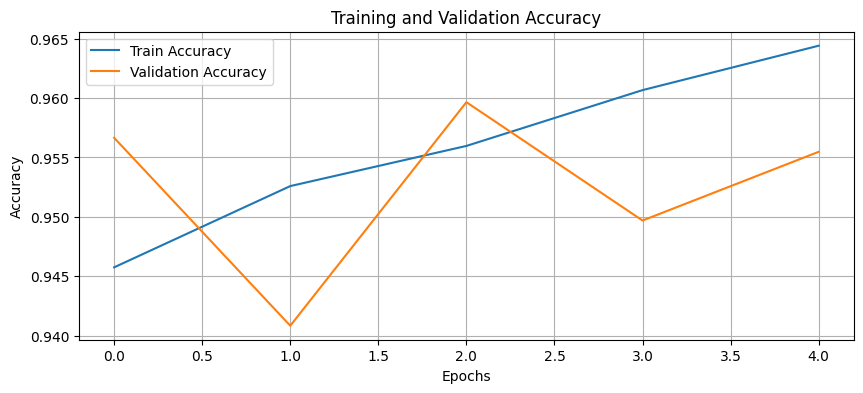

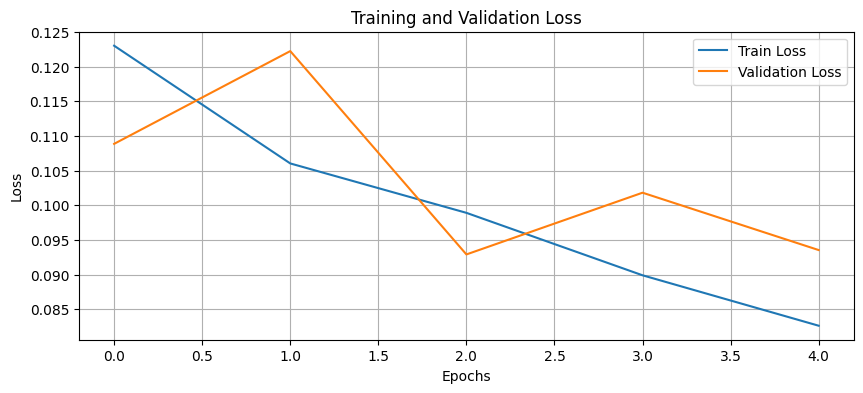

In [39]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


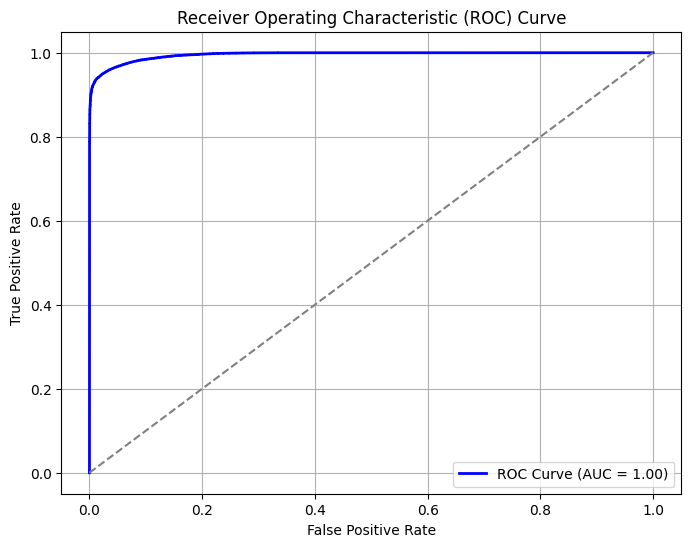

In [40]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

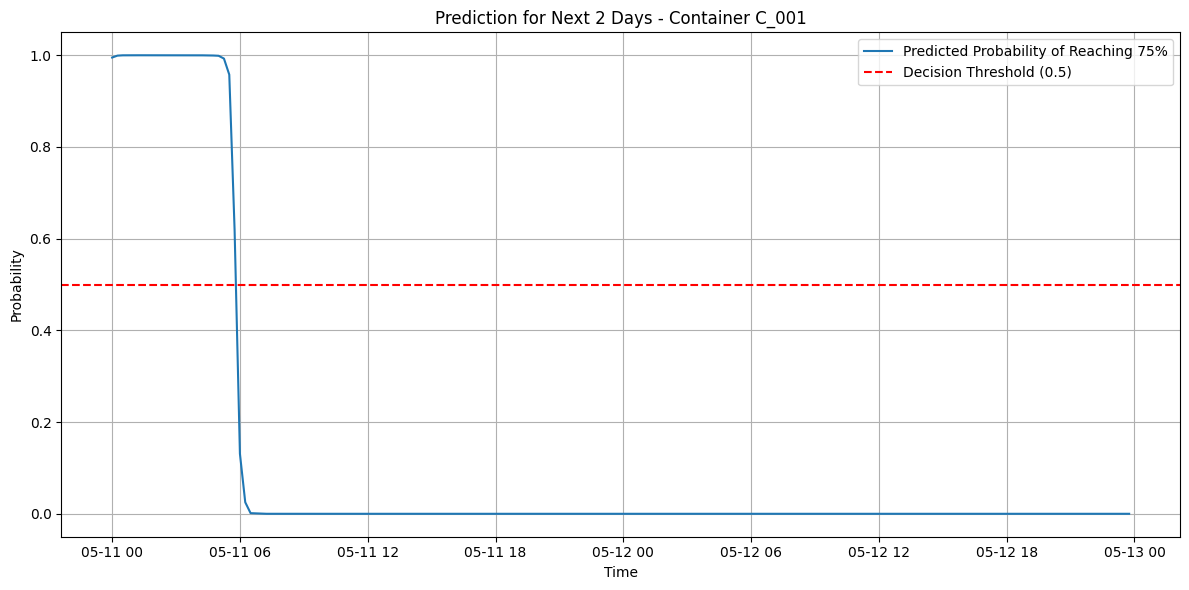

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have df, the full dataset loaded
# Select a container for demonstration
container_id = 'C_001'
container_df = df[df['Container_ID'] == container_id][['Timestamp', 'Fill_Level']].copy()
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.sort_values('Timestamp', inplace=True)

# Get the last 10 fill levels for prediction start
last_sequence = container_df['Fill_Level'].values[-10:]

# Prepare sequences for the next 2 days (192 timesteps at 15 min intervals)
future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(192):  # 192 steps = 2 days * 24 hours * 4 (15 min steps per hour)
    # Prepare input
    input_seq = scaler.transform(current_sequence.reshape(-1, 1)).reshape((1, 10, 1))
    # Predict probability of reaching 75% in next N hours
    pred = model.predict(input_seq)[0][0]
    future_predictions.append(pred)
    # Simulate next fill level assuming normal accumulation if no reset
    next_fill = current_sequence[-1] + np.random.uniform(1, 3)
    next_fill = min(next_fill, 100)
    current_sequence = np.append(current_sequence[1:], next_fill)

# Plot Predictions
future_timestamps = pd.date_range(start=container_df['Timestamp'].max(), periods=192, freq='15min')

plt.figure(figsize=(12, 6))
plt.plot(future_timestamps, future_predictions, label='Predicted Probability of Reaching 75%')
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title(f"Prediction for Next 2 Days - Container {container_id}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


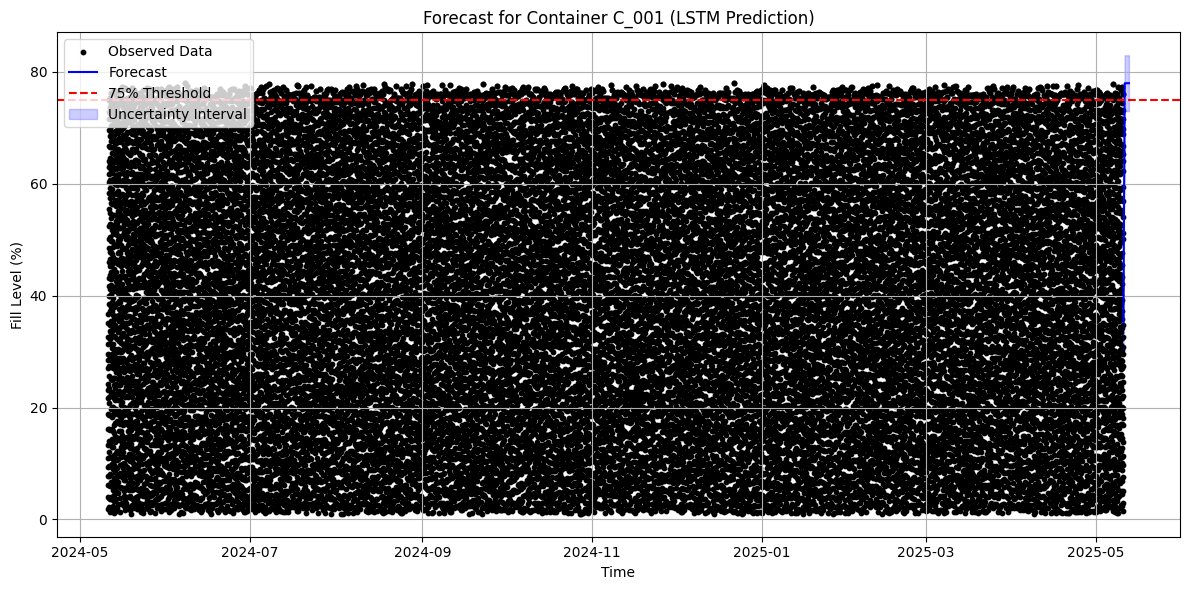

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming your model is trained and you have:
# - model: Trained LSTM model
# - scaler: MinMaxScaler used for normalization
# - container_df: DataFrame with 'Timestamp' and 'Fill_Level' for the container

# Configuration
container_id = 'C_001'
THRESHOLD = 75
PREDICTION_HOURS = 48  # Next 2 days
TIME_INTERVAL_MIN = 15
future_steps = int((PREDICTION_HOURS * 60) / TIME_INTERVAL_MIN)
sequence_length = 10

# Prepare last sequence for prediction
last_sequence = scaler.transform(container_df['Fill_Level'].values[-sequence_length:].reshape(-1, 1)).flatten()
predicted_fill_levels = []
timestamps_future = pd.date_range(start=container_df['Timestamp'].max(), periods=future_steps, freq='15min')

for _ in range(future_steps):
    input_seq = last_sequence.reshape((1, sequence_length, 1))
    pred_prob = model.predict(input_seq, verbose=0)[0][0]
    # Simulate next fill level (you can replace with real logic if needed)
    next_fill = last_sequence[-1] + scaler.transform([[np.random.uniform(1, 3)]])[0][0]
    next_fill = min(next_fill, 1.0)
    last_sequence = np.append(last_sequence[1:], next_fill)
    predicted_fill_levels.append(next_fill)

# Inverse scale predictions back to percentage
predicted_fill_levels = scaler.inverse_transform(np.array(predicted_fill_levels).reshape(-1, 1)).flatten()

# Plot Styled Like Prophet
plt.figure(figsize=(12, 6))
plt.scatter(container_df['Timestamp'], container_df['Fill_Level'], color='black', s=10, label='Observed Data')
plt.plot(timestamps_future, predicted_fill_levels, color='blue', label='Forecast')
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.fill_between(timestamps_future, predicted_fill_levels - 5, predicted_fill_levels + 5, color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title(f"Forecast for Container {container_id} (LSTM Prediction)")
plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


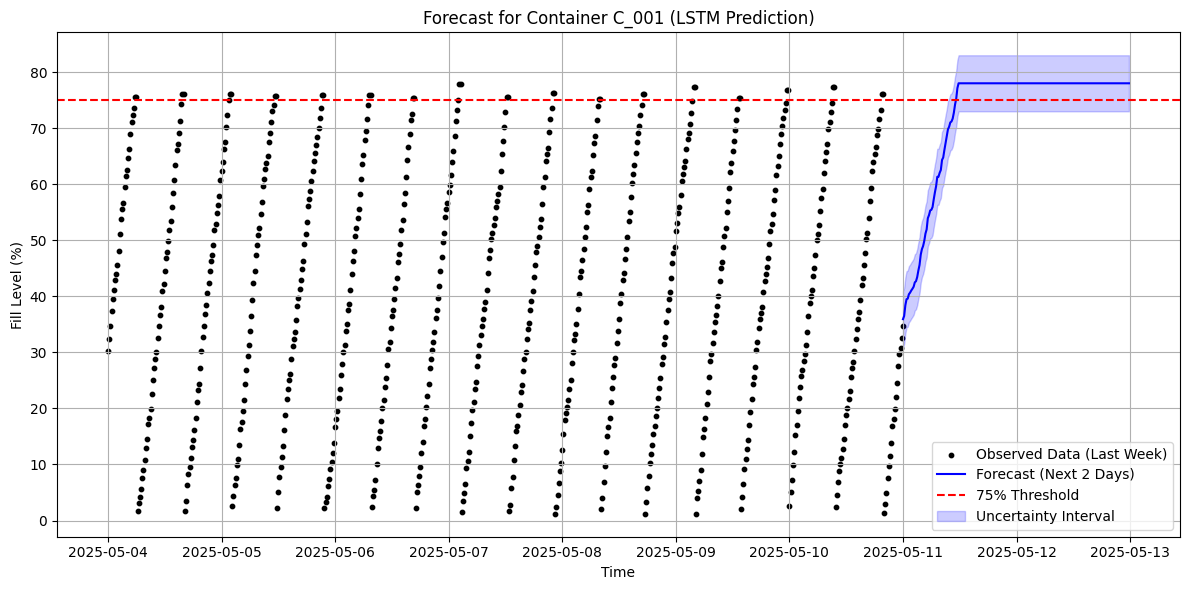

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming your model is trained and you have:
# - model: Trained LSTM model
# - scaler: MinMaxScaler used for normalization
# - container_df: DataFrame with 'Timestamp' and 'Fill_Level' for the container

# Configuration
container_id = 'C_001'
THRESHOLD = 75
PREDICTION_HOURS = 48  # Next 2 days
TIME_INTERVAL_MIN = 15
future_steps = int((PREDICTION_HOURS * 60) / TIME_INTERVAL_MIN)
sequence_length = 10

# Filter last 7 days of historical data
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
last_date = container_df['Timestamp'].max()
first_date = last_date - pd.Timedelta(days=7)
history_df = container_df[container_df['Timestamp'] >= first_date]

# Prepare last sequence for prediction
last_sequence = scaler.transform(container_df['Fill_Level'].values[-sequence_length:].reshape(-1, 1)).flatten()
predicted_fill_levels = []
timestamps_future = pd.date_range(start=container_df['Timestamp'].max(), periods=future_steps, freq='15min')

for _ in range(future_steps):
    input_seq = last_sequence.reshape((1, sequence_length, 1))
    pred_prob = model.predict(input_seq, verbose=0)[0][0]
    next_fill = last_sequence[-1] + scaler.transform([[np.random.uniform(1, 3)]])[0][0]
    next_fill = min(next_fill, 1.0)
    last_sequence = np.append(last_sequence[1:], next_fill)
    predicted_fill_levels.append(next_fill)

predicted_fill_levels = scaler.inverse_transform(np.array(predicted_fill_levels).reshape(-1, 1)).flatten()

# Plot Styled Like Prophet (Last Week Only)
plt.figure(figsize=(12, 6))
plt.scatter(history_df['Timestamp'], history_df['Fill_Level'], color='black', s=10, label='Observed Data (Last Week)')
plt.plot(timestamps_future, predicted_fill_levels, color='blue', label='Forecast (Next 2 Days)')
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.fill_between(timestamps_future, predicted_fill_levels - 5, predicted_fill_levels + 5, color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title(f"Forecast for Container {container_id} (LSTM Prediction)")
plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load your dataset
df = pd.read_csv('/kaggle/working/final_dataset_truck_fields_filled_1.csv')

# Example for one container
container_id = 'C_001'
container_df = df[df['Container_ID'] == container_id].copy()
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.sort_values('Timestamp', inplace=True)

# Feature Engineering
container_df['Hour'] = container_df['Timestamp'].dt.hour
container_df['DayOfWeek'] = container_df['Timestamp'].dt.dayofweek
container_df['Minute'] = container_df['Timestamp'].dt.minute
container_df['Time_Step'] = np.arange(len(container_df))

# Encode Waste_Type if needed
le = LabelEncoder()
container_df['Waste_Type_Encoded'] = le.fit_transform(container_df['Waste_Type'])

features = ['Hour', 'DayOfWeek', 'Minute', 'Time_Step', 'Waste_Type_Encoded']
target = 'Fill_Level'

X = container_df[features]
y = container_df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [46]:
# Train XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 25.64


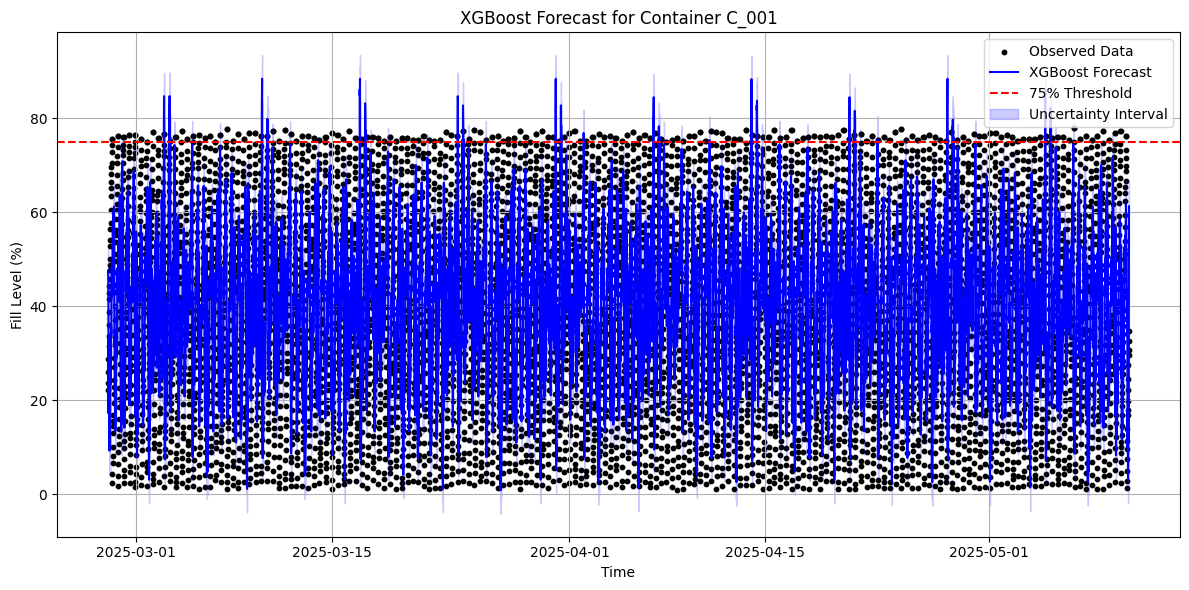

In [47]:
# Plot
plt.figure(figsize=(12, 6))
plt.scatter(container_df['Timestamp'].iloc[len(X_train):], y_test, color='black', s=10, label='Observed Data')
plt.plot(container_df['Timestamp'].iloc[len(X_train):], y_pred, color='blue', label='XGBoost Forecast')
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.fill_between(container_df['Timestamp'].iloc[len(X_train):], y_pred - 5, y_pred + 5, color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title(f"XGBoost Forecast for Container {container_id}")
plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScal

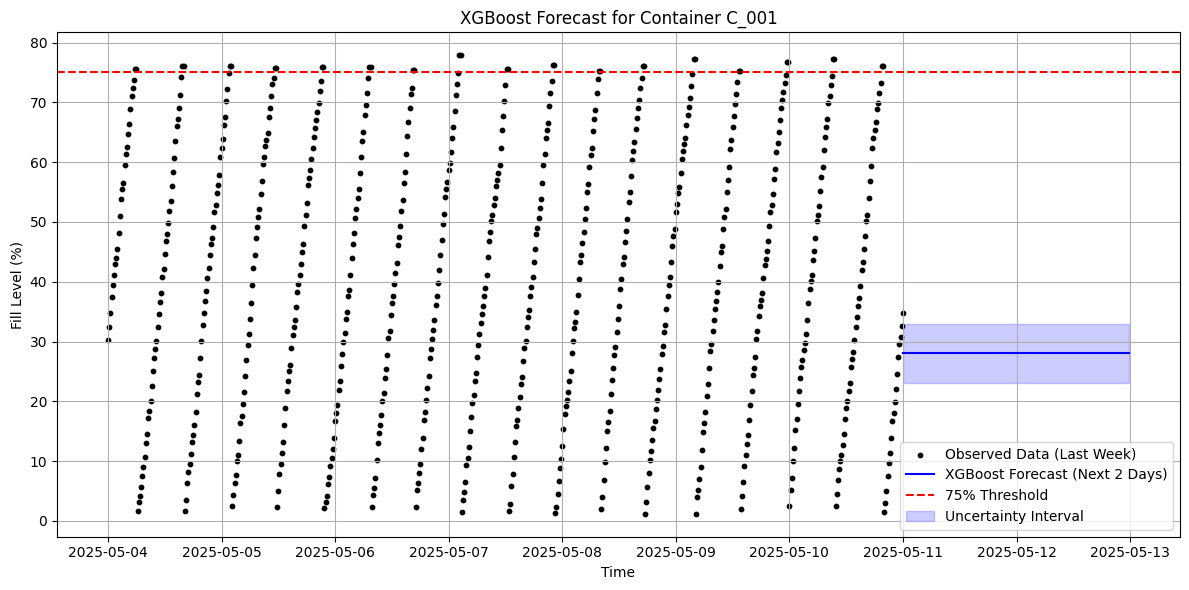

In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('/kaggle/working/final_dataset_truck_fields_filled_1.csv')

# Configuration
container_id = 'C_001'
PREDICTION_HOURS = 48  # 2 days
TIME_INTERVAL_MIN = 15
future_steps = int((PREDICTION_HOURS * 60) / TIME_INTERVAL_MIN)

# Prepare container data
container_df = df[df['Container_ID'] == container_id].copy()
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.sort_values('Timestamp', inplace=True)

# Filter last week for plotting
last_date = container_df['Timestamp'].max()
first_date = last_date - pd.Timedelta(days=7)
history_df = container_df[container_df['Timestamp'] >= first_date]

# Feature Engineering
container_df['Hour'] = container_df['Timestamp'].dt.hour
container_df['DayOfWeek'] = container_df['Timestamp'].dt.dayofweek
container_df['Minute'] = container_df['Timestamp'].dt.minute
container_df['Time_Step'] = np.arange(len(container_df))

le = LabelEncoder()
container_df['Waste_Type_Encoded'] = le.fit_transform(container_df['Waste_Type'])

features = ['Hour', 'DayOfWeek', 'Minute', 'Time_Step', 'Waste_Type_Encoded']
target = 'Fill_Level'

X = container_df[features]
y = container_df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=future_steps/len(X), shuffle=False)

# Train XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict next 2 days
last_row = X.iloc[-1].copy()
future_predictions = []
future_timestamps = pd.date_range(start=container_df['Timestamp'].max(), periods=future_steps, freq='15min')

for step in range(future_steps):
    last_row['Time_Step'] += 1  # Increment Time_Step for each future prediction
    future_features = scaler.transform(last_row.values.reshape(1, -1))
    pred = model.predict(future_features)[0]
    future_predictions.append(pred)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(history_df['Timestamp'], history_df['Fill_Level'], color='black', s=10, label='Observed Data (Last Week)')
plt.plot(future_timestamps, future_predictions, color='blue', label='XGBoost Forecast (Next 2 Days)')
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.fill_between(future_timestamps, np.array(future_predictions) - 5, np.array(future_predictions) + 5,
                 color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title(f"XGBoost Forecast for Container {container_id}")
plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2025-05-17 17:10:01.950517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747501802.235799      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747501802.316182      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_31/592526348.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = container_df[['Timestamp', 'Fill_Level']].set_index('Timestamp').resample('H').mean().interpolate()
2025-05-17 17:10:17.628156: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Container: C_001
Accuracy: 0.995
F1-score: 0.000
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      1740
           1      0.000     0.000     0.000         8

    accuracy                          0.995      1748
   macro avg      0.498     0.500     0.499      1748
weighted avg      0.991     0.995     0.993      1748



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


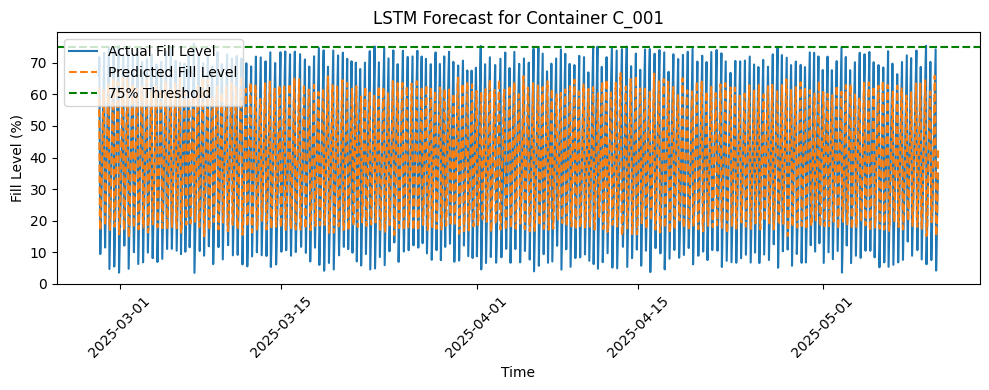

/tmp/ipykernel_31/592526348.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = container_df[['Timestamp', 'Fill_Level']].set_index('Timestamp').resample('H').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [1]:
import pandas as pd

# Load merged dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# LSTM Parameters
seq_length = 24  # Last 24 hours to predict next hour
epochs = 10      # Reduce for faster testing

for container_id in df['Container_ID'].unique():
    container_df = df[df['Container_ID'] == container_id].copy()
    container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
    container_df.sort_values('Timestamp', inplace=True)
    ts_data = container_df[['Timestamp', 'Fill_Level']].set_index('Timestamp').resample('H').mean().interpolate()

    if len(ts_data) <= seq_length:
        continue  # Skip if not enough data

    # Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(ts_data)

    # Create sequences
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, seq_length)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build LSTM
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    # Predict and inverse transform
    predictions = model.predict(X_test)
    predictions_inverse = scaler.inverse_transform(predictions)
    y_test_inverse = scaler.inverse_transform(y_test)

    # ---- Evaluation as classification ----
    y_true_binary = (y_test_inverse >= 75).astype(int)
    y_pred_binary = (predictions_inverse >= 75).astype(int)

    f1 = f1_score(y_true_binary, y_pred_binary)
    acc = accuracy_score(y_true_binary, y_pred_binary)

    print(f"\nContainer: {container_id}")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1-score: {f1:.3f}")
    print(classification_report(y_true_binary, y_pred_binary, digits=3))

    # ---- Plot ----
    timestamps = ts_data.index[-len(y_test_inverse):]
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, y_test_inverse, label='Actual Fill Level')
    plt.plot(timestamps, predictions_inverse, label='Predicted Fill Level', linestyle='--')
    plt.axhline(y=75, color='green', linestyle='--', label='75% Threshold')
    plt.title(f"LSTM Forecast for Container {container_id}")
    plt.xlabel("Time")
    plt.ylabel("Fill Level (%)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


RMSE: 25.64
Accuracy: 0.940
F1-score: 0.028
              precision    recall  f1-score   support

           0      0.949     0.990     0.969      6651
           1      0.080     0.017     0.028       358

    accuracy                          0.940      7009
   macro avg      0.515     0.503     0.498      7009
weighted avg      0.905     0.940     0.921      7009



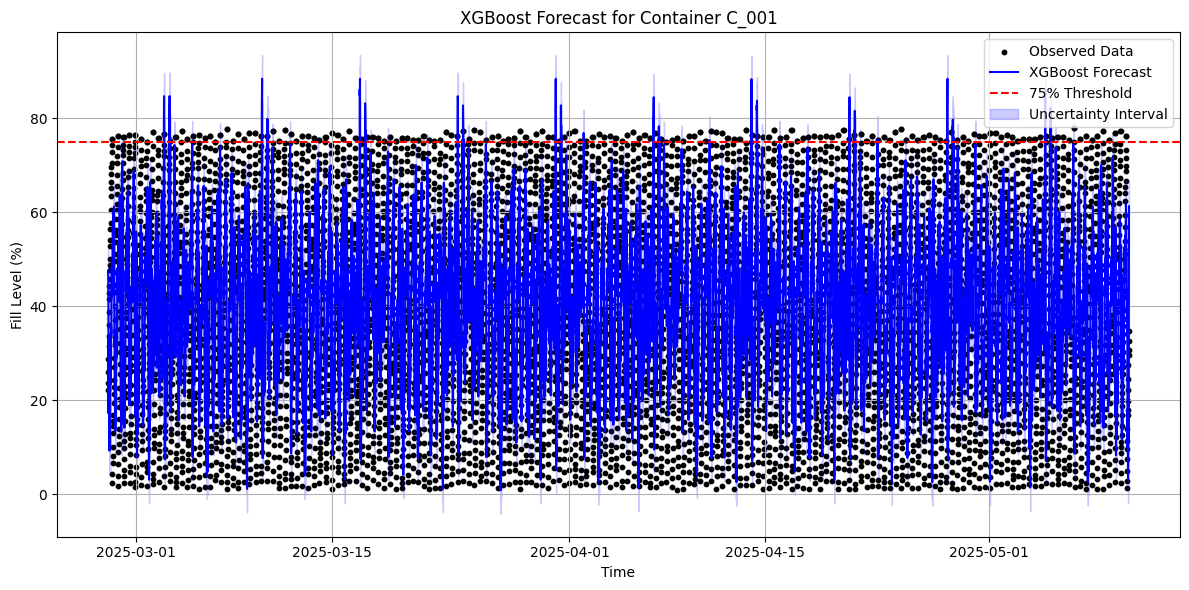

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report

# Load your dataset
df = pd.read_csv('/kaggle/input/correct/final_dataset_correct_truck_arrival.csv')

# Example for one container
container_id = 'C_001'
container_df = df[df['Container_ID'] == container_id].copy()
container_df['Timestamp'] = pd.to_datetime(container_df['Timestamp'])
container_df.sort_values('Timestamp', inplace=True)

# Feature Engineering
container_df['Hour'] = container_df['Timestamp'].dt.hour
container_df['DayOfWeek'] = container_df['Timestamp'].dt.dayofweek
container_df['Minute'] = container_df['Timestamp'].dt.minute
container_df['Time_Step'] = np.arange(len(container_df))

# Encode Waste_Type
le = LabelEncoder()
container_df['Waste_Type_Encoded'] = le.fit_transform(container_df['Waste_Type'])

features = ['Hour', 'DayOfWeek', 'Minute', 'Time_Step', 'Waste_Type_Encoded']
target = 'Fill_Level'

X = container_df[features]
y = container_df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation (Regression)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# ---- Classification Evaluation ----
threshold = 75
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred >= threshold).astype(int)

f1 = f1_score(y_test_class, y_pred_class)
acc = accuracy_score(y_test_class, y_pred_class)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(classification_report(y_test_class, y_pred_class, digits=3))

# ---- Plot ----
plt.figure(figsize=(12, 6))
timestamps = container_df['Timestamp'].iloc[len(X_train):]
plt.scatter(timestamps, y_test, color='black', s=10, label='Observed Data')
plt.plot(timestamps, y_pred, color='blue', label='XGBoost Forecast')
plt.axhline(y=75, color='red', linestyle='--', label='75% Threshold')
plt.fill_between(timestamps, y_pred - 5, y_pred + 5, color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title(f"XGBoost Forecast for Container {container_id}")
plt.xlabel("Time")
plt.ylabel("Fill Level (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
